In [1]:
import pandas as pd
from scipy.stats import wasserstein_distance
#import keras
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Concatenate
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
#from tensorflow.keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import energyflow as ef
from energyflow.archs import CNN, DNN
from sklearn.utils import class_weight, shuffle
import matplotlib.pyplot as plt

In [2]:
nFeat = 4
n_gen = 400000

In [3]:
innerdata_train = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/Datasets/preprocessed_data_6var/innerdata_train_6var.npy")
# innerdata_train_cut1 = np.where(innerdata_train[:,0]<0.3)
# innerdata_train = innerdata_train[innerdata_train_cut1]
# innerdata_train_cut2 = np.where(innerdata_train[:,1]<0.3)
# innerdata_train = innerdata_train[innerdata_train_cut2]
plt.hist(innerdata_train[:,4], bins=60)
plt.show()


# Load Data for Classification

In [4]:
# load real mc sample
innerdata_train = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/Datasets/preprocessed_data_6var/innerdata_train_6var.npy")
innerdata_train_cut1 = np.where(innerdata_train[:,1]<0.3)
innerdata_train = innerdata_train[innerdata_train_cut1]
innerdata_train_cut2 = np.where(innerdata_train[:,2]<0.3)
innerdata_train = innerdata_train[innerdata_train_cut2]
X_mc_train = innerdata_train[:,1:nFeat+1]
print("shape of X_mc_train: ", X_mc_train.shape)
innerdata_val = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/Datasets/preprocessed_data_6var/innerdata_val_6var.npy")
innerdata_val_cut1 = np.where(innerdata_val[:,1]<0.3)
innerdata_val = innerdata_val[innerdata_val_cut1]
innerdata_val_cut2 = np.where(innerdata_val[:,2]<0.3)
innerdata_val = innerdata_val[innerdata_val_cut2]
X_mc_val = innerdata_val[:,1:nFeat+1]
print("shape of X_mc_val: ", X_mc_val.shape)

# load generated bkg sample
# gen_SR = np.load("fake_SR_cbvae_6var_n400000_BestModels.npy")
fileNameNN = '/global/homes/a/agarabag/LHCO2020-cVAE/pre_trained_data/cBVAE-6var/gen_data/LHCO2020_cB-VAE_events_lr1en3_ConvF_SR.csv'
gen_SR = pd.read_csv(fileNameNN, delimiter = ' ', header=None, index_col=False)
gen_SR = gen_SR.to_numpy()
gen_SR_cut1 = np.where(gen_SR[:,0]<0.3)
gen_SR = gen_SR[gen_SR_cut1]
gen_SR_cut2 = np.where(gen_SR[:,1]<0.3)
gen_SR = gen_SR[gen_SR_cut2]
print(gen_SR.shape)
gen_SR = gen_SR[:,:nFeat]
print("shape of gen_SR: ", gen_SR.shape)
gen_SR_train = gen_SR[:int(n_gen/2)]
print("shape of gen_SR_train", gen_SR_train.shape)
gen_SR_val = gen_SR[int(n_gen/2):]
print("shape of gen_SR_val", gen_SR_val.shape)

# load test mc sample
innerdata_test = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/Datasets/preprocessed_data_6var/innerdata_test_6var.npy")
innerdata_extrabkg_test = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/Datasets/preprocessed_data_6var/innerdata_extrabkg_test_6var.npy")
innerdata_test = np.concatenate((innerdata_test, innerdata_extrabkg_test), axis=0)
innerdata_test_cut1 = np.where(innerdata_test[:,1]<0.3)
innerdata_test = innerdata_test[innerdata_test_cut1]
innerdata_test_cut2 = np.where(innerdata_test[:,2]<0.3)
innerdata_test = innerdata_test[innerdata_test_cut2]
X_mc_test = innerdata_test[:,1:nFeat+1]
print("shape of X_mc_test: ", X_mc_test.shape)

shape of X_mc_train:  (44982, 4)
shape of X_mc_val:  (44925, 4)
(323442, 6)
shape of gen_SR:  (323442, 4)
shape of gen_SR_train (200000, 4)
shape of gen_SR_val (123442, 4)
shape of X_mc_test:  (259116, 4)


In [5]:
print(gen_SR[:,3])
print("#############################")
plt.hist(gen_SR[:,0], bins=60)
plt.hist(gen_SR[:,1], bins=60)
plt.show()

[0.48882216 0.53541732 0.41433522 ... 0.3859615  0.37027949 0.82875061]
#############################


In [6]:
X_train_mc_and_gen = np.concatenate((X_mc_train, gen_SR_train), axis=0)
print("shape of training mc and data combination: ", X_train_mc_and_gen.shape)

X_val_mc_and_gen = np.concatenate((X_mc_val, gen_SR_val), axis=0)
print("shape of val mc and data combination: ", X_val_mc_and_gen.shape)

shape of training mc and data combination:  (244982, 4)
shape of val mc and data combination:  (168367, 4)


In [7]:
y_train_mc = np.ones(X_mc_train.shape[0])
print("shape of train_mc label: ", y_train_mc.shape)

y_train_gen = np.zeros(gen_SR_train.shape[0])
print("shape of train_gen label: ", y_train_gen.shape)

y_val_mc = np.ones(X_mc_val.shape[0])
print("shape of val_mc label: ", y_val_mc.shape)

y_val_gen = np.zeros(gen_SR_val.shape[0])
print("shape of val_gen label: ", y_val_gen.shape)

y_mc_test = innerdata_test[:,nFeat+3]
print("shape of mc_test label: ", y_mc_test.shape)


shape of train_mc label:  (44982,)
shape of train_gen label:  (200000,)
shape of val_mc label:  (44925,)
shape of val_gen label:  (123442,)
shape of mc_test label:  (259116,)


In [8]:
y_train_mc_and_gen = np.concatenate((y_train_mc, y_train_gen), axis=0)
print("shape of training mc and data label combination: ", y_train_mc_and_gen.shape)

y_val_mc_and_gen = np.concatenate((y_val_mc, y_val_gen), axis=0)
print("shape of val mc and data label combination: ", y_val_mc_and_gen.shape)

shape of training mc and data label combination:  (244982,)
shape of val mc and data label combination:  (168367,)


In [9]:
shuffle_seed = 42
X_train_mc_and_gen, y_train_mc_and_gen = shuffle(X_train_mc_and_gen, y_train_mc_and_gen, random_state = shuffle_seed)
X_val_mc_and_gen, y_val_mc_and_gen = shuffle(X_val_mc_and_gen, y_val_mc_and_gen, random_state = shuffle_seed)
X_mc_test, y_mc_test = shuffle(X_mc_test, y_mc_test, random_state = shuffle_seed)

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_mc_and_gen)
#transform training dataset
X_train_mc_and_gen = scaler.transform(X_train_mc_and_gen)
# transform val dataset
X_val_mc_and_gen = scaler.transform(X_val_mc_and_gen)


In [11]:
# transform test dataset
X_mc_test = scaler.transform(X_mc_test)

In [12]:
# es = callbacks.EarlyStopping(monitor='loss',min_delta = 1e-3, mode='min', verbose=1, patience=5)
optimizer = Adam(lr=1e-3)
model = Sequential()
model.add(Dense(64, input_dim=nFeat, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = tf.keras.callbacks.History()
num_epoch=50
batch_size=128
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_mc_and_gen),y_train_mc_and_gen)
class_weights_dict = dict(enumerate(class_weights))

class CustomSaver(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.save("/global/u2/a/agarabag/LHCO2020-cVAE/classifier_cbvae_6varInput_4varTrain/model_cbvae_4var_cut0.3_epoch{}.h5".format(epoch))

saver = CustomSaver()

/global/homes/a/agarabag/.conda/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [14]:
model.fit(X_train_mc_and_gen, y_train_mc_and_gen, 
        epochs=num_epoch,
        batch_size=batch_size,
        class_weight=class_weights_dict,
        validation_data=(X_val_mc_and_gen, y_val_mc_and_gen), 
        shuffle=shuffle,
        verbose=1,callbacks=[history,saver])

Train on 244982 samples, validate on 168367 samples


2022-09-08 13:18:11.928930: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-08 13:18:12.398035: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-08 13:18:12.398137: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cori16): /proc/driver/nvidia/version does not exist
2022-09-08 13:18:12.401001: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-09-08 13:18:12.415099: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300030000 Hz
2022-09-08 13:18:12.418024: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555559391860 initialized for platform Host (this does not guarantee that XLA will be used). Devices:


Epoch 1/50
244982/244982 [==============================] - 5s 19us/sample - loss: 0.6926 - acc: 0.5232 - val_loss: 0.6988 - val_acc: 0.4870
Epoch 2/50
244982/244982 [==============================] - 4s 17us/sample - loss: 0.6918 - acc: 0.5197 - val_loss: 0.6924 - val_acc: 0.4963
Epoch 3/50
244982/244982 [==============================] - 4s 17us/sample - loss: 0.6915 - acc: 0.5182 - val_loss: 0.6867 - val_acc: 0.5626
Epoch 4/50
244982/244982 [==============================] - 4s 17us/sample - loss: 0.6911 - acc: 0.5008 - val_loss: 0.6901 - val_acc: 0.5194
Epoch 5/50
244982/244982 [==============================] - 4s 17us/sample - loss: 0.6909 - acc: 0.5144 - val_loss: 0.6982 - val_acc: 0.4763
Epoch 6/50
244982/244982 [==============================] - 4s 17us/sample - loss: 0.6907 - acc: 0.5089 - val_loss: 0.6899 - val_acc: 0.5235
Epoch 7/50
244982/244982 [==============================] - 4s 17us/sample - loss: 0.6903 - acc: 0.5116 - val_loss: 0.6910 - val_acc: 0.5180
Epoch 8/50
24

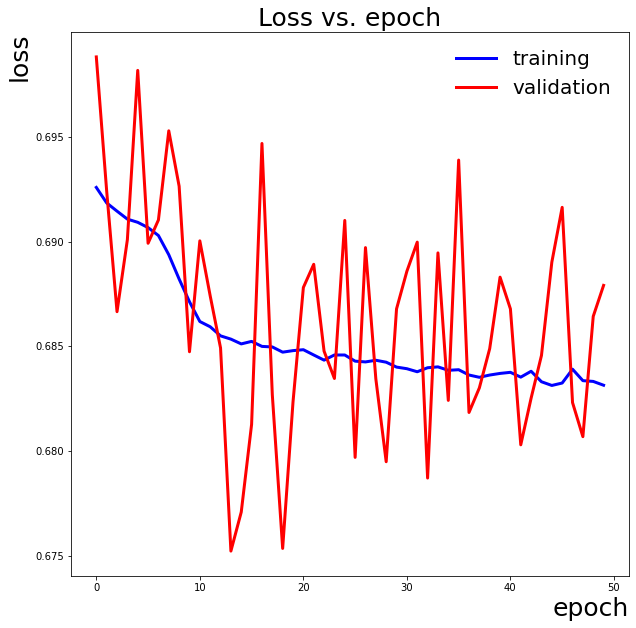

In [15]:
"""
Accuracy of training and validating
"""
fig1, ax1 = plt.subplots(1,1, figsize=(10,10))

# plt.plot(np.arange(0,num_epoch), history.history['acc'], label='training',c='blue',linewidth = 3)
# plt.plot(np.arange(0,num_epoch), history.history['val_acc'], label='validation',c='red',linewidth = 3)
plt.plot(history.history['acc'], label='training',c='blue',linewidth = 3)
plt.plot(history.history['val_acc'], label='validation',c='red',linewidth = 3)

plt.title("Accuracy vs. epoch", fontsize=25)

ax1.set_ylabel('accuracy', fontsize=25,horizontalalignment='right',y=1)
ax1.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

plt.show()


"""
Loss of training and validating
"""

fig2, ax2 = plt.subplots(1,1, figsize=(10,10))

plt.plot(np.arange(0,num_epoch), history.history['loss'], label='training',c='blue',linewidth = 3)
plt.plot(np.arange(0,num_epoch), history.history['val_loss'], label='validation',c='red',linewidth = 3)

plt.title("Loss vs. epoch", fontsize=25)

ax2.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax2.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

plt.show()

In [16]:
num_models = 10
idx_best_models = np.argpartition(history.history['val_loss'], num_models)[:num_models]

Train_Predictions = []
Val_Predictions = []
Test_Predictions = []
for idx in idx_best_models:
    model_temp = keras.models.load_model("/global/u2/a/agarabag/LHCO2020-cVAE/classifier_cbvae_6varInput_4varTrain/model_cbvae_4var_cut0.3_epoch"+str(idx)+".h5")
    Train_Predictions.append(model_temp.predict(X_train_mc_and_gen))
    Val_Predictions.append(model_temp.predict(X_val_mc_and_gen))
    Test_Predictions.append(model_temp.predict(X_mc_test))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
predict_train = np.mean(Train_Predictions, axis=0)
print(predict_train.shape)

predict_val = np.mean(Val_Predictions, axis=0)
print(predict_val.shape)

predict_test = np.mean(Test_Predictions, axis=0)
np.save("/global/u2/a/agarabag/LHCO2020-cVAE/predictions/predict_test_cbvae_6varInput_4varTrain_cut0.3_pytorch.npy", predict_test)
print(predict_test.shape)

(244982, 1)
(168367, 1)
(259116, 1)


In [18]:


auc_train = roc_auc_score(y_train_mc_and_gen, predict_train)
roc_train = roc_curve(y_train_mc_and_gen, predict_train)

auc_val = roc_auc_score(y_val_mc_and_gen, predict_val)
roc_val = roc_curve(y_val_mc_and_gen, predict_val)

auc_test = roc_auc_score(y_mc_test, predict_test)
roc_test = roc_curve(y_mc_test, predict_test)

In [19]:
FalsePositive_test = roc_test[0]
TruePositive_test = roc_test[1]

pass_cut = np.where(FalsePositive_test>1.8382353*1e-5)
FalsePositive_test, TruePositive_test = FalsePositive_test[pass_cut], TruePositive_test[pass_cut]

FalsePositive_test.sort()
TruePositive_test.sort()

In [20]:
fpr_nonzero = np.delete(FalsePositive_test, np.argwhere(FalsePositive_test == 0))
tpr_nonzero = np.delete(TruePositive_test, np.argwhere(TruePositive_test == 0))


print(FalsePositive_test, "########", TruePositive_test, "#######", fpr_nonzero, "########", tpr_nonzero)
print(len(fpr_nonzero[2:]), len(tpr_nonzero))

[0.00264874 0.00264874 0.00431055 ... 0.99699627 0.99699627 1.        ] ######## [0.00000000e+00 3.61271676e-04 3.61271676e-04 ... 9.99638728e-01
 1.00000000e+00 1.00000000e+00] ####### [0.00264874 0.00264874 0.00431055 ... 0.99699627 0.99699627 1.        ] ######## [3.61271676e-04 3.61271676e-04 7.22543353e-04 ... 9.99638728e-01
 1.00000000e+00 1.00000000e+00]
34148 34149


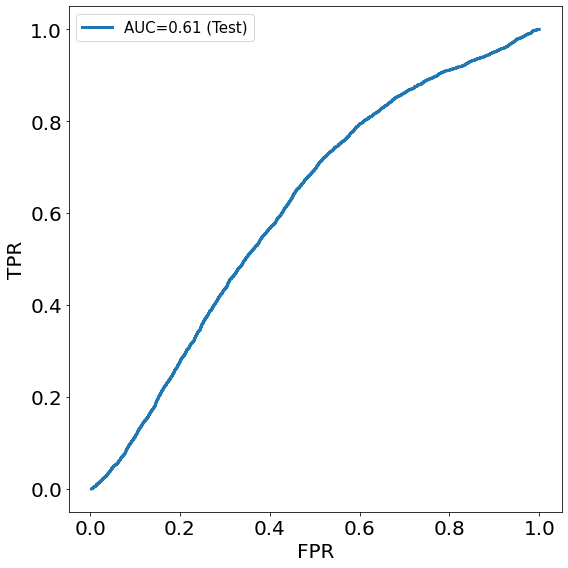

In [21]:
"""
Generate ROC figure
"""
fig3, ax3 = plt.subplots(1,1, figsize=(8,8))

plt.plot(FalsePositive_test, TruePositive_test, linewidth = 3, linestyle="-", label='AUC={0:.2f} (Test)'.format(auc_test))

ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
plt.ylabel("TPR",fontsize=20)
plt.xlabel("FPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()

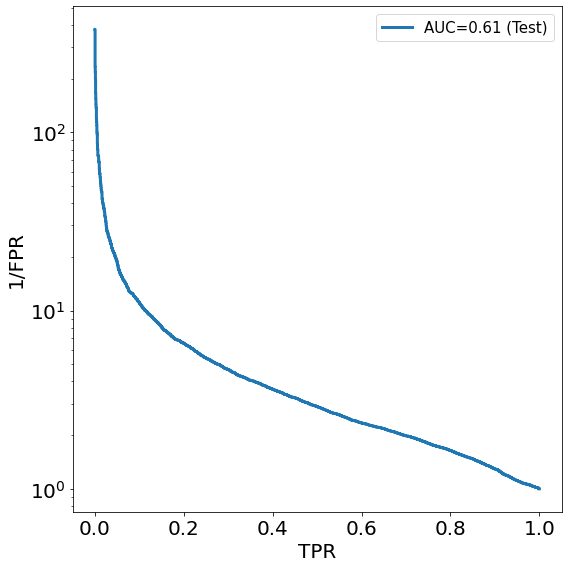

In [22]:
"""
Generate ROC figure
"""
fig5, ax5 = plt.subplots(1,1, figsize=(8,8))

plt.plot(TruePositive_test, 1/FalsePositive_test, linewidth = 3, linestyle="-", label='AUC={0:.2f} (Test)'.format(auc_test))

ax5.tick_params(axis='x', labelsize=20)
ax5.tick_params(axis='y', labelsize=20)
plt.yscale("log")
plt.ylabel("1/FPR",fontsize=20)
plt.xlabel("TPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


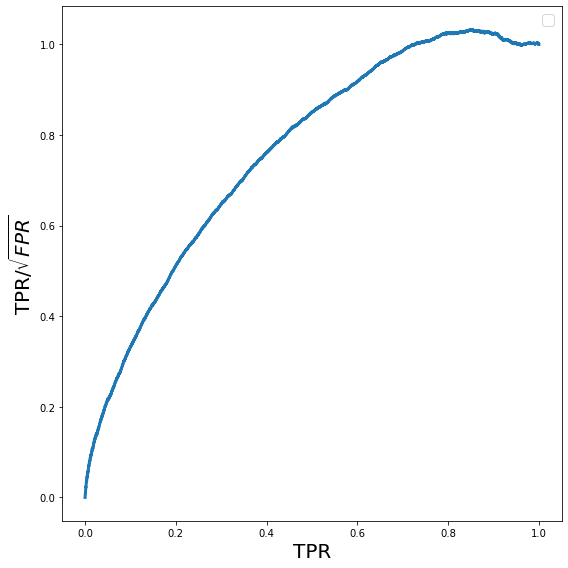

In [23]:
"""
Generate SIC figure
"""
fig4, ax4 = plt.subplots(1,1, figsize=(8,8))

plt.plot(TruePositive_test, TruePositive_test/np.sqrt(FalsePositive_test), linewidth = 3, linestyle="-")
# plt.plot(tpr_nonzero, tpr_nonzero/np.sqrt(fpr_nonzero[2:]), linewidth = 3, linestyle="-")


ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
plt.ylabel(r'TPR/$\sqrt{FPR}$',fontsize=20)
plt.xlabel("TPR",fontsize=20)
plt.legend(ncol=1,fontsize=15) 
plt.tight_layout()

plt.show()

In [13]:
predict_2p_cbvae = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/predictions/predict_test_cbvae_6varInput_4varTrain_pytorch.npy")
predict_2p_ideal = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/predictions/predict_test_ideal_6varInput_4varTrain.npy")
predict_2p_cath = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/predictions/predict_test_cathode_4var.npy")

In [14]:
cathode_pred = predict_2p_cath[:,1]

Text(0.5, 1.0, 'Classifier scores')

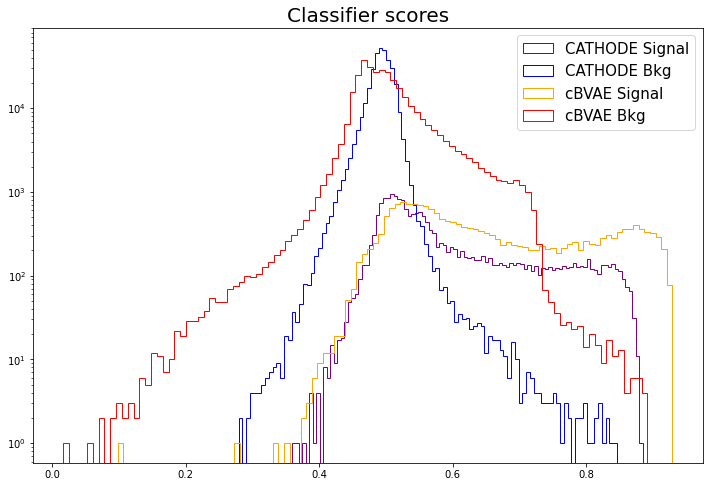

In [15]:
fig7, ax7 = plt.subplots(1,1,figsize=(12,8))

is_sig = np.where(y_mc_test==1)
is_bkg = np.where(y_mc_test==0)

plt.hist(cathode_pred[is_sig], bins=100, stacked=False, histtype='step', color="purple", label='CATHODE Signal')
plt.hist(cathode_pred[is_bkg], bins=100, stacked=False, histtype='step', color="blue", label='CATHODE Bkg')
plt.hist(predict_2p_cbvae[is_sig], bins=100, stacked=False, histtype='step', color="orange", label='cBVAE Signal')
plt.hist(predict_2p_cbvae[is_bkg], bins=100, stacked=False, histtype='step', color="red", label='cBVAE Bkg')

plt.yscale('log')
plt.legend(loc="upper right", fontsize=15)
plt.title('Classifier scores', fontsize=20)

Text(0.5, 1.0, 'Classifier scores')

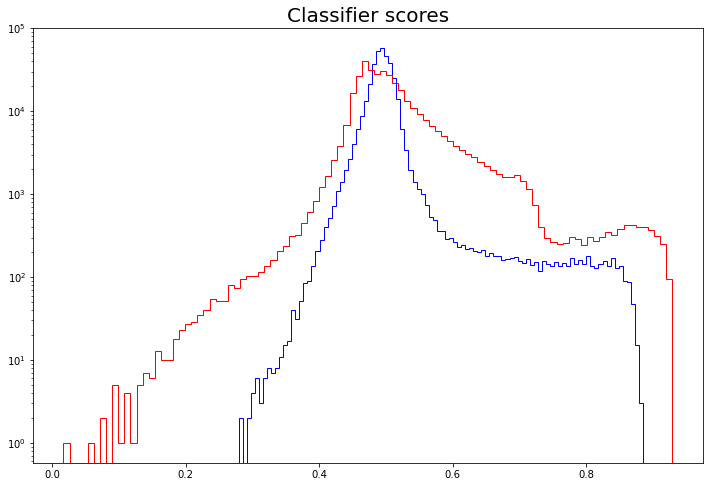

In [28]:
fig7, ax7 = plt.subplots(1,1,figsize=(12,8))
plt.hist(cathode_pred, bins=100, stacked=False, histtype='step', color="blue", label='CATHODE')
plt.hist(predict_2p_cbvae, bins=100, stacked=False, histtype='step', color="red", label='cBVAE')
plt.yscale('log')
plt.legend(loc="upper right", fontsize=15)
plt.title('Classifier scores', fontsize=20)

In [30]:
fig7, ax7 = plt.subplots(1,1,figsize=(12,8))
plt.scatter(cathode_pred, predict_2p_cbvae, s=0.1)
plt.xlabel("CATHODE Score")
plt.ylabel("VAE Score")
plt.title('Classifier scores', fontsize=20)

Text(0.5, 1.0, 'Classifier scores')

In [65]:
fig7, ax7 = plt.subplots(1,1,figsize=(12,8))

is_sig = np.where(y_mc_test==1)
is_bkg = np.where(y_mc_test==0)

plt.hist(predict_test[is_sig], bins=100, stacked=False, histtype='step', color="red", label='Signal')
plt.hist(predict_test[is_bkg], bins=100, stacked=False, histtype='step', color="deepskyblue", label='Bkg')

plt.yscale('log')
plt.legend(loc="upper right", fontsize=15)
plt.title('DNN scores (test)', fontsize=20)

Text(0.5, 1.0, 'DNN scores (test)')

In [ ]:
"""
Generate SIC figure comparison
"""
# fig8, ax8 = plt.subplots(1,1, figsize=(8,8))

predict_2p_cbvae = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/predictions/predict_test_cbvae_6varInput_4varTrain_pytorch.npy")
predict_2p_ideal = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/predictions/predict_test_ideal_6varInput_4varTrain.npy")
predict_2p_cath = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/predictions/predict_test_cathode_4var.npy")

roc_2p_cbvae = roc_curve(y_mc_test, predict_2p_cbvae)
roc_2p_ideal = roc_curve(y_mc_test, predict_2p_ideal)
roc_2p_cath = roc_curve(y_mc_test, predict_2p_cath[:,1])

fpr_2p_cbvae, tpr_2p_cbvae = roc_2p_cbvae[0], roc_2p_cbvae[1]
fpr_2p_ideal, tpr_2p_ideal = roc_2p_ideal[0], roc_2p_ideal[1]
fpr_2p_cath, tpr_2p_cath = roc_2p_cath[0], roc_2p_cath[1]

idx_2p_cbvae = np.where(fpr_2p_cbvae>1.8382353*1e-5)
idx_2p_ideal = np.where(fpr_2p_ideal>1.8382353*1e-5)
idx_2p_cath = np.where(fpr_2p_cath>1.8382353*1e-5)

fpr_2p_cbvae, tpr_2p_cbvae = fpr_2p_cbvae[idx_2p_cbvae], tpr_2p_cbvae[idx_2p_cbvae]
fpr_2p_ideal, tpr_2p_ideal = fpr_2p_ideal[idx_2p_ideal], tpr_2p_ideal[idx_2p_ideal]
fpr_2p_cath, tpr_2p_cath = fpr_2p_cath[idx_2p_cath], tpr_2p_cath[idx_2p_cath]

intrested_tpr_region = np.where((tpr_2p_cbvae < 0.8) & (tpr_2p_cbvae > 0.3))

print(len(tpr_2p_cbvae[intrested_tpr_region]), len(predict_2p_cbvae[intrested_tpr_region]), len(y_mc_test[intrested_tpr_region]))

new_cbvae_pred = predict_2p_cbvae[intrested_tpr_region]
new_y_mc_test  = y_mc_test[intrested_tpr_region]
is_sig = np.where(new_y_mc_test==1)
is_bkg = np.where(new_y_mc_test==0)
print(new_cbvae_pred)

fig7, ax7 = plt.subplots(1,1,figsize=(12,8))
new_is_sig = np.where(y_mc_test==1)
new_is_bkg = np.where(y_mc_test==0)
# plt.hist(cathode_pred[is_sig], bins=100, stacked=False, histtype='step', color="purple", label='CATHODE Signal')
# plt.hist(cathode_pred[is_bkg], bins=100, stacked=False, histtype='step', color="blue", label='CATHODE Bkg')
plt.hist(new_cbvae_pred[new_is_sig], bins=100, stacked=False, histtype='step', color="orange", label='cBVAE Signal')
plt.hist(new_cbvae_pred[new_is_bkg], bins=100, stacked=False, histtype='step', color="red", label='cBVAE Bkg')
plt.yscale('log')
plt.legend(loc="upper right", fontsize=15)
plt.title('Classifier scores', fontsize=20)

plt.show()

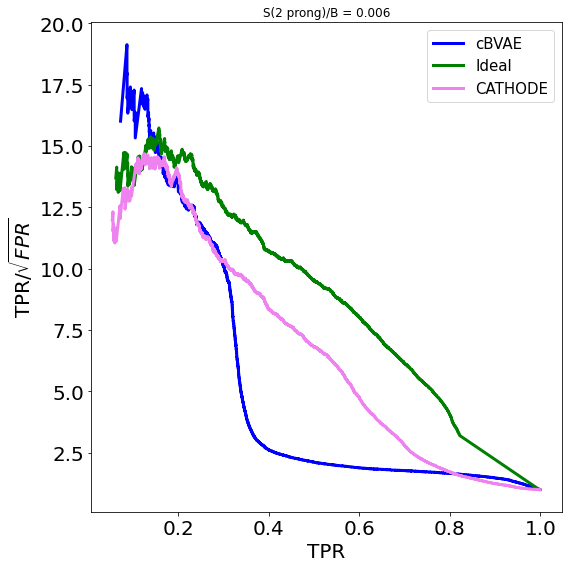

In [11]:
"""
Generate SIC figure comparison
"""
fig8, ax8 = plt.subplots(1,1, figsize=(8,8))

predict_2p_cbvae = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/predictions/predict_test_cbvae_6varInput_4varTrain_pytorch.npy")
predict_2p_ideal = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/predictions/predict_test_ideal_6varInput_4varTrain.npy")
predict_2p_cath = np.load("/global/u2/a/agarabag/LHCO2020-cVAE/predictions/predict_test_cathode_4var.npy")

roc_2p_cbvae = roc_curve(y_mc_test, predict_2p_cbvae)
roc_2p_ideal = roc_curve(y_mc_test, predict_2p_ideal)
roc_2p_cath = roc_curve(y_mc_test, predict_2p_cath[:,1])

fpr_2p_cbvae, tpr_2p_cbvae = roc_2p_cbvae[0], roc_2p_cbvae[1]
fpr_2p_ideal, tpr_2p_ideal = roc_2p_ideal[0], roc_2p_ideal[1]
fpr_2p_cath, tpr_2p_cath = roc_2p_cath[0], roc_2p_cath[1]

idx_2p_cbvae = np.where(fpr_2p_cbvae>1.8382353*1e-5)
idx_2p_ideal = np.where(fpr_2p_ideal>1.8382353*1e-5)
idx_2p_cath = np.where(fpr_2p_cath>1.8382353*1e-5)

fpr_2p_cbvae, tpr_2p_cbvae = fpr_2p_cbvae[idx_2p_cbvae], tpr_2p_cbvae[idx_2p_cbvae]
fpr_2p_ideal, tpr_2p_ideal = fpr_2p_ideal[idx_2p_ideal], tpr_2p_ideal[idx_2p_ideal]
fpr_2p_cath, tpr_2p_cath = fpr_2p_cath[idx_2p_cath], tpr_2p_cath[idx_2p_cath]


plt.plot(tpr_2p_cbvae, tpr_2p_cbvae/np.sqrt(fpr_2p_cbvae), linewidth = 3, linestyle="-", color="blue", label="cBVAE")
plt.plot(tpr_2p_ideal, tpr_2p_ideal/np.sqrt(fpr_2p_ideal), linewidth = 3, linestyle="-", color="green", label="Ideal")
plt.plot(tpr_2p_cath, tpr_2p_cath/np.sqrt(fpr_2p_cath), linewidth = 3, linestyle="-", color="violet", label="CATHODE")

ax8.tick_params(axis='x', labelsize=20)
ax8.tick_params(axis='y', labelsize=20)
plt.ylabel(r'TPR/$\sqrt{FPR}$',fontsize=20)
plt.xlabel("TPR",fontsize=20)
plt.legend(ncol=1,fontsize=15)
plt.title("S(2 prong)/B = 0.006")
plt.tight_layout()

plt.show()

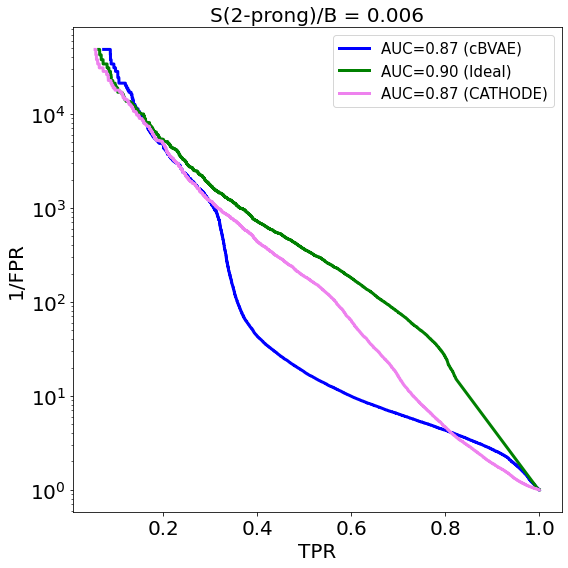

In [12]:
"""
Generate ROC figure comparison
"""
fig9, ax9 = plt.subplots(1,1, figsize=(8,8))

auc_2p_cbvae = roc_auc_score(y_mc_test, predict_2p_cbvae)
auc_2p_ideal = roc_auc_score(y_mc_test, predict_2p_ideal)
auc_2p_cath = roc_auc_score(y_mc_test, predict_2p_cath[:,1])

plt.plot(tpr_2p_cbvae, 1/fpr_2p_cbvae, linewidth = 3, linestyle="-", color="blue", label='AUC={0:.2f} (cBVAE)'.format(auc_2p_cbvae))
plt.plot(tpr_2p_ideal, 1/fpr_2p_ideal, linewidth = 3, linestyle="-", color="green", label='AUC={0:.2f} (Ideal)'.format(auc_2p_ideal))
plt.plot(tpr_2p_cath, 1/fpr_2p_cath, linewidth = 3, linestyle="-", color="violet", label='AUC={0:.2f} (CATHODE)'.format(auc_2p_cath))

ax9.tick_params(axis='x', labelsize=20)
ax9.tick_params(axis='y', labelsize=20)
plt.ylabel('1/FPR',fontsize=20)
plt.xlabel("TPR",fontsize=20)
plt.legend(ncol=1,fontsize=15)
plt.title("S(2-prong)/B = 0.006", fontsize=20)
plt.yscale("log")
plt.tight_layout()

plt.show()